<a href="https://colab.research.google.com/github/ampnb/machine-learning2022/blob/main/04_Multinomial_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Wanchanok Sunthorn"
ID = "st122053"

---

# Machine Learning Lab 04: Multinomial Logistic Regression


## Generalized Linear Models

From lecture, we know that members of the exponential family distributions can be written in the form
$$p(y;\eta) = b(y)e^{(\eta^\top T(y)-a(\eta))},$$
where
- $\eta$ is the natural parameter or canonical paramter of the distribution,
- $T(y)$ is the sufficient statistic (we normally use $T(y) = y$),
- $b(y)$ is an arbitrary scalar function of y, and
- $a(\eta)$ is the log partition function. We use $e^{a(\eta)}$ just to normalize the distribution to have a sum or integral of 1.

Each choice of $T$, $a$, and $b$ defines a family (set) of distributions parameterized by $\eta$.

If we can write $p(y \mid \mathbf{x} ; \theta)$ as a member of the exponential family of distributions with parameters $\mathbf{\eta}$ with
$\eta_i = \theta^\top_i \mathbf{x}$, we obtain a *generalized linear model* that can be optimized using the maximum likelihood principle.

The GLM for the Gaussian distribution with natural parameter $\eta$ being the mean of the Gaussian gives us ordinary linear regression.

The Bernoulli distribution with parameter $\phi$ can be written as an exponential distribution
with natural parmeter $\eta = \log \frac{\phi}{1-\phi}$. The GLM for this distribution is logistic regression.

When we write the multinomial distribution with paremeters $\phi_i > 0$ for classes $i \in 1..K$ with the constraint that
$$\sum_{i=1}^{K} \phi_i = 1$$ as a member of the exponential family,
the resulting GLM is called *multinomial logistic regression*. The parameters $\phi_1, \ldots, \phi_K$ are written
in terms of $\theta$ as
$$\phi_i = p(y = i \mid \mathbf{x}; \theta) = \frac{e^{\theta^\top_i \mathbf{x}}}{\sum_{j=1}^{K}e^{\theta^\top_j \mathbf{x}}}. $$

## Optimizing a Multinomial Regression Model

In multinomial regression, we have

1. Data are pairs $\mathbf{x}^{(i)}, y^{(i)}$ with $\mathbf{x}^{(i)} \in \mathbb{R}^n$ and
   $y \in 1..K$.
   
2. The hypothesis is a vector-valued function
$$\mathbf{h}_\theta(\mathbf{x}) = \begin{bmatrix} p(y = 1 \mid \mathbf{x} ; \theta) \\
                                         p(y = 2 \mid \mathbf{x} ; \theta) \\
                                         \vdots \\
                                         p(y = K \mid \mathbf{x} ; \theta) \end{bmatrix},$$
    where $$p(y = i \mid \mathbf{x}) = \phi_i = p(y = i \mid \mathbf{x}; \theta) = \frac{e^{\theta^\top_i \mathbf{x}}}{\sum_{j=1}^{K}e^{\theta^\top_j \mathbf{x}}}. $$

We need a cost function and a way to minimize that cost function. As usual, we try to find the parameters maximizing the likelihood or log likelihood function, or equivalently, minimizing the negative log likelihood function:

$$\theta^* = \text{argmax}_\theta {\cal L}(\theta) =
             \text{argmax}_\theta \ell(\theta) =
             \text{argmin}_\theta J(\theta),$$
where
$$\begin{eqnarray}
   J(\theta) & = & - \ell(\theta) \\
   & = & - \sum_{i=1}^m \log p(y^{(i)} \mid \textbf{x}^{(i)} ; \theta).
   \end{eqnarray}$$

Now that we know what is $J(\theta)$, let's try to find its minimimum by taking the derivatives with respect to an arbitrary parameter $\theta_{kl}$, the $l$-th element of the parameter vector $\theta_k$ for class $k$. Before we start, let's define a variable $a_k$ as the linear activation for class $k$ in the softmax function:
$$ a_k = \theta_k^\top \mathbf{x}^{(i)}, $$
and rewrite the softmax more conveniently as
$$ \phi_k = \frac{e^{a_k}}{\sum_{j=1}^K e^{a_j}}. $$
That makes it a little easier to compute the gradient:
$$\begin{eqnarray}
   \frac{\partial J}{\partial \theta_{kl}} & = & - \sum_{i=1}^m \frac{1}{\phi_{y^{(i)}}} \frac{\partial \phi_{y^{(i)}}}{\partial \theta_{kl}}. \\
   \end{eqnarray}$$
Using the chain rule, we have
$$\frac{\partial \phi_{y^{(i)}}}{\partial \theta_{kl}} = \sum_{j=1}^K \frac{\partial \phi_{y^{(i)}}}{\partial a_j} \frac{\partial a_j}{\partial \theta_{kl}}$$
The second factor is easy:
$$ \frac{\partial a_j}{\partial \theta_{kl}} = \delta(k=j)x^{(i)}_l. $$
For the first factor, we have
$$\begin{eqnarray}
\frac{\partial \phi_{y^{(i)}}}{\partial a_j}
& = & \frac{ \left[ \delta(y^{(i)}=j)e^{a_j} \sum_{c=1}^K e^{a_c} \right] - e^{a_j} e^{a_j} }{\left[ \sum_{c=1}^K e^{a_c} \right]^2} \\
& = & \delta(y^{(i)}=j) \phi_j - \phi_j^2
\end{eqnarray}$$

Substituting what we've derived into the definition above, we obtain
$$ \frac{\partial J}{\theta_{kl}} = - \sum_{i=1}^m \sum_{j=1}^K (\delta(y^{(i)}=j) - \phi_j) \frac{\partial a_j}{\partial \theta_{kl}}. $$

There are two ways to do the calculation.
In deep neural networks with multinomial outputs, we want to first calculate the $\frac{\partial J}{\partial a_j}$ terms then use them to calculate $\frac{\partial J}{\partial \theta_{kl}}$.

However, if we only have the "single layer" model described up till now, we note
that
$$\frac{\partial a_j}{\partial \theta_{kl}} = \delta(j=k) x^{(i)}_l,$$
so we can simplify as follows:
$$\begin{eqnarray}
  \frac{\partial J}{\theta_{kl}} & = & - \sum_{i=1}^m \sum_{j=1}^K (\delta(y^{(i)}=j) - \phi_j) \frac{\partial a_j}{\partial \theta_{kl}} \\
  & = & - \sum_{i=1}^m \sum_{j=1}^K (\delta(y^{(i)}=j) - \phi_j) \delta(j=k) x^{(i)}_l \\
  & = & - \sum_{i=1}^m (\delta(y^{(i)}=k) - \phi_k) x^{(i)}_l \\
  \end{eqnarray}$$

## Put It Together

OK! Now we have all 4 criteria for our multinomial regression model:

1. Data are pairs $\mathbf{x}^{(i)}, y^{(i)}$ with $\mathbf{x}^{(i)} \in \mathbb{R}^n$ and
   $y \in 1..K$.
   
2. The hypothesis is a vector-valued function
$$\mathbf{h}_\theta(\mathbf{x}) = \begin{bmatrix} p(y = 1 \mid \mathbf{x} ; \theta) \\
                                         p(y = 2 \mid \mathbf{x} ; \theta) \\
                                         \vdots \\
                                         p(y = K \mid \mathbf{x} ; \theta) \end{bmatrix},$$
    where $$p(y = i \mid \mathbf{x}) = \phi_i = p(y = i \mid \mathbf{x}; \theta) = \frac{e^{\theta^\top_i \mathbf{x}}}{\sum_{j=1}^{K}e^{\theta^\top_j \mathbf{x}}}. $$
    
3. The cost function is
   $$J(\theta) = - \sum_{i=1}^m \log p(y^{(i)} \mid \textbf{x}^{(i)})$$
   
4. The optimization algorithm is gradient descent on $J(\theta)$ with the update rule
   $$\theta_{kl}^{(n+1)} \leftarrow \theta_{kl}^{(n)} - \alpha \sum_{i=1}^m (\delta(y^{(i)}=k) - \phi_k) x^{(i)}_l.$$


## Multinomial Regression Example

The following example of multinomial logistic regression is from [Kaggle](https://www.kaggle.com/saksham219/softmax-regression-for-iris-classification).

The data set is the famous [Iris dataset from the UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/iris).

The data contain 50 samples from each of three classes. Each class refers to a particular species of the iris plant. 
The data include four independent variables:
1. Sepal length in cm
2. Sepal width in cm
3. Petal length in cm
4. Petal width in cm

The target takes on one of three classes:
1. Iris Setosa
2. Iris Versicolour
3. Iris Virginica
   
To predict the target value, we use multinomial logistic regression for $k=3$ classes i.e. $y \in \{ 1, 2, 3 \}$. 

Given $\mathbf{x}$, we would like to predict a probability distribution over the
three outcomes for $y$, i.e., $\phi_1 = p(y=1 \mid \mathbf{x})$, $\phi_2 = p(y=2 \mid \mathbf{x})$, and $\phi_3 = p(y=3 \mid \mathbf{x})$.


In [ ]:
# importing libraries
import numpy as np
import pandas as pd 
import random
import math

The `phi` function returns $\phi_i$ for input patterns $\mathtt{X}$ and parameters $\theta$.

In [ ]:
def phi(i, theta, X, num_class):
    """
    Here is how to make documentation for your function show up in intellisense.
    Explanation you put here will be shown when you use it.
    
    To get intellisense in your Jupyter notebook:
        - Press 'TAB' after typing a dot (.) to see methods and attributes
        - Press 'Shift+TAB' after typing a function name to see its documentation

    The `phi` function returns phi_i = h_theta(x) for input patterns X and parameters theta.
    
    Inputs:
        i=index of phi
        
        X=input dataset
        
        theta=parameters

    Returns:
        phi_i
    """
    mat_theta = np.matrix(theta[i])
    mat_x = np.matrix(X)
    num = math.exp(np.dot(mat_theta, mat_x.T))
    den = 0
    for j in range(0,num_class):
        mat_theta_j = np.matrix(theta[j])
        den = den + math.exp(np.dot(mat_theta_j, mat_x.T))
    phi_i = num / den
    return phi_i

**Tips for using intellisense: Shift+TAB**

![lab4-01.png](attachment:lab4-01.png)

The `grad_cost` function gives the gradient of the cost for data $\mathtt{X}, \mathbf{y}$ for class $j\in 1..k$.

In [ ]:
def indicator(i, j):
    '''
    Check whether i is equal to j
    
    Return:
        1 when i=j, otherwise 0
    '''
    if i == j: return 1
    else: return 0


def grad_cost(X, y, j, theta, num_class):
    '''
    Compute the gradient of the cost function for data X, y for parameters of
    output for class j in 1..k
    '''
    m, n = X.shape
    sum = np.array([0 for i in range(0,n)])
    for i in range(0, m):
        p = indicator(y.iloc[i], j) - phi(j, theta, X.iloc[i], num_class)
        sum = sum + (X.iloc[i] * p)
    grad = -sum / m
    return grad

def gradient_descent(X, y, theta, alpha, iters, num_class):
    '''
    Perform iters iterations of gradient descent: theta_new = theta_old - alpha * cost
    '''
    n = X.shape[1]
    for iter in range(iters):
        dtheta = np.zeros((num_class, n))
        for j in range(0, num_class):
            dtheta[j,:] = grad_cost(X, y, j, theta, num_class)
        theta = theta - alpha * dtheta
    return theta

def h(X, theta, num_class):
    '''
    Hypothesis function: h_theta(X) = theta * X
    '''
    X = np.matrix(X)
    h_matrix = np.empty((num_class,1))
    den = 0
    for j in range(0, num_class):
        den = den + math.exp(np.dot(theta[j], X.T))
    for i in range(0,num_class):
        h_matrix[i] = math.exp(np.dot(theta[i], X.T))
    h_matrix = h_matrix / den
    return h_matrix

## Exercise 1.1 (5 points)

Create a function to load **data** from **Iris.csv** using the Pandas library and extract y from the data.

You can use [the Pandas 10 minute guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) to learn how to use pandas.

In [ ]:
def load_data(file_name, drop_label, y_label, is_print=False):
    # 1. Load csv file
    data = pd.read_csv(file_name)
    if is_print:
        print(data.head())
    # 2. remove 'Id' column from data
    if drop_label is not None:
        data = data.drop([drop_label],axis=1)
        if is_print:
            print(data.head())
    # 3. Extract y_label column as y from data
    y = data[y_label]
    # 4. get index of y-column
    y_index = data.columns.get_loc(y_label)
    # 5. Extrack X features from data
    X = data.iloc[:,:y_index]
    # YOUR CODE HERE
    #raise NotImplementedError()
    return X, y

In [ ]:
X, y = load_data('Iris.csv', 'Id', 'Species', True)
print(X.head())
print(y[:5])

# Test function: Do not remove
# tips: this is how to create dataset using pandas
d_ex = {'ID':     [  1,   2,   3,    4,    5,    6,    7],
        'Grade':  [3.5, 2.5, 3.0, 3.75, 2.83, 3.95, 2.68],
        'Type':   ['A', 'B', 'C',  'A',  'C',  'A',  'B']
        }
df = pd.DataFrame (d_ex, columns = ['ID','Grade', 'Type'])
df.to_csv('out.csv', index=False)

Xtest, ytest = load_data('out.csv', 'ID', 'Type')
assert len(Xtest.columns) == 1, 'number of X_columns incorrect (1)'
assert ytest.name == 'Type', 'Extract y_column is incorrect (1)'
assert ytest.shape == (7,), 'number of y is incorrect (1)'
assert 'Grade' in Xtest.columns, 'Incorrect columns in X (1)'
Xtest, ytest = load_data('out.csv', None, 'Type')
assert len(Xtest.columns) == 2, 'number of X_columns incorrect (2)'
assert ytest.name == 'Type', 'Extract y_column is incorrect (2)'
assert ytest.shape == (7,), 'number of y is incorrect (2)'
assert 'Grade' in Xtest.columns and 'ID' in Xtest.columns, 'Incorrect columns in X (2)'
import os
os.remove('out.csv')

assert len(X.columns) == 4, 'number of X_columns incorrect (3)'
assert 'SepalWidthCm' in X.columns and 'Id' not in X.columns and 'Species' not in X.columns, 'Incorrect columns in X (3)'
assert y.name == 'Species', 'Extract y_column is incorrect (3)'
assert y.shape == (150,), 'number of y is incorrect (3)'

print("success!")
# End Test function

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa
1            4.9           3.0            1.4           0.2  Iris-setosa
2            4.7           3.2            1.3           0.2  Iris-setosa
3            4.6           3.1            1.5           0.2  Iris-setosa
4            5.0           3.6            1.4           0.2  Iris-setosa
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0            5.1           3.5          

**Expected result**: \
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm \
0            5.1           3.5            1.4           0.2\
1            4.9           3.0            1.4           0.2\
2            4.7           3.2            1.3           0.2\
3            4.6           3.1            1.5           0.2\
4            5.0           3.6            1.4           0.2\
0    Iris-setosa\
1    Iris-setosa\
2    Iris-setosa\
3    Iris-setosa\
4    Iris-setosa\
Name: Species, dtype: object

## Exercise 1.2 (10 points)

Partition data into training and test sets
- No need to use random.seed function!
- Ensure that the train set is 70% and the test set is 30% of the data.
- Encode the labels in the y attribute to be integers in the range 0..k-1.

<details>
    <summary><font size="3" color="green"><b>Hint:</b></font></summary>
    You can use the <tt>partition</tt> function from lab02 if you like
    <p></p>
    <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html">panda.iloc</a> must be used to extract data from an index list
    <p></p>
    <a href="https://pandas.pydata.org/docs/reference/api/pandas.unique.html">panda.unique</a> will give you the set of unique labels
</details>

In [ ]:
def partition(X, y, percent_train):
    # 1. create index list
    
    
    # 2. shuffle index
    # 3. Create train/test index
    # 4. Separate X_Train, y_train, X_test, y_test
    # 5. Get y_labels_name from y using pandas.unique function
    # 6. Change y_labels_name into string number and put into y_labels_new
    # 7. Drop shuffle index columns
    #     - pandas.reset_index() and pandas.drop(...) might be help
    
    y_labels_name = None
    y_labels_new = None
    
    # YOUR CODE HERE
    idx = np.arange(0, X.shape[0])
    np.random.shuffle(idx)
    
    middle = int(X.shape[0] * percent_train)
    idx_train = idx[0:middle]
    idx_test = idx[middle:]

    y_labels_name = y.unique()
    len_labels = len(y_labels_name)
    
    X_train = X.iloc[idx_train]
    X_test = X.iloc[idx_test]
    y_train = y.iloc[idx_train]
    y_test = y.iloc[idx_test]
    
    y_labels_new = np.arange(len_labels).tolist()
    
    

    for i in range(len_labels):
      y_train.replace(y_labels_name[i], y_labels_new[i], inplace=True)
      y_test.replace(y_labels_name[i], y_labels_new[i], inplace=True)
    
    # raise NotImplementedError()


# 7. Drop shuffle index columns
# - pandas.reset_index() and pandas.drop(...) might be help 
      X_train.reset_index(inplace=True, drop=True) 
      X_test.reset_index(inplace=True, drop=True) 
      y_train.reset_index(inplace=True, drop=True) 
      y_test.reset_index(inplace=True, drop=True)

    
    return idx, X_train, y_train, X_test, y_test, y_labels_name, y_labels_new

In [ ]:
    y_labels_name = y.unique()


In [ ]:
percent_train = 0.7
idx, X_train, y_train, X_test, y_test, y_labels_name, y_labels_new = partition(X, y, percent_train)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_labels_name: ', y_labels_name)
print('y_labels_new: ', y_labels_new)
print(X_train.head())
print(y_train.head())

# Test function: Do not remove
assert len(y_labels_name) == 3 and len(y_labels_new) == 3, 'number of y uniques are incorrect'
assert X_train.shape == (105, 4), 'Size of X_train is incorrect'
assert X_test.shape == (45, 4), 'Size of x_test is incorrect'
assert y_train.shape == (105, ), 'Size of y_train is incorrect'
assert y_test.shape == (45, ), 'Size of y_test is incorrect'
assert 'Iris-setosa' in y_labels_name and 'Iris-virginica' in y_labels_name and \
        'Iris-versicolor' in y_labels_name, 'y unique data incorrect'
assert min(y_labels_new) == 0 and max(y_labels_new) < 3, 'label indices are incorrect'

print("success!")
# End Test function

X_train.shape (105, 4)
X_test.shape (45, 4)
y_train.shape (105,)
y_test.shape (45,)
y_labels_name:  ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
y_labels_new:  [0, 1, 2]
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0            7.9           3.8            6.4           2.0
1            4.4           2.9            1.4           0.2
2            5.8           2.6            4.0           1.2
3            6.7           3.1            4.7           1.5
4            6.3           2.7            4.9           1.8
0    2
1    0
2    1
3    1
4    2
Name: Species, dtype: int64
success!


**Expected result**: <span style="color:blue">(*or similar*)</span>\
X_train.shape (105, 4)\
X_test.shape (45, 4)\
y_train.shape (105,)\
y_test.shape (45,)\
y_labels_name:  ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica'] \
y_labels_new:  [0, 1, 2]

SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm\
0            6.4           2.8            5.6           2.2\
1            6.7           3.3            5.7           2.1\
2            4.6           3.4            1.4           0.3\
3            5.1           3.8            1.5           0.3\
4            5.0           2.3            3.3           1.0\
   Species\
0        2\
1        2\
2        0\
3        0\
4        1

## Exercise 1.3 (5 points)

Train your classification model using the `gradient_descent` function already provided.
You might also play around with the gradient descent function to see if you can speed it up!

In [ ]:
# num_class is the number of unique labels
num_class = len(y_labels_name)

if (X_train.shape[1] == X.shape[1]): 
    X_train.insert(0, "intercept", 1)

# Reset m and n for training data
r, c = X_train.shape

# Initialize theta for each class
theta_initial = np.ones((num_class, c))

alpha = .05
iterations = 200

theta = None
# Logistic regression
# YOUR CODE HERE

theta = gradient_descent(X_train, y_train, theta_initial, alpha, iterations, num_class)

#raise NotImplementedError()

In [ ]:
print(theta)
print(theta.shape)

# Test function: Do not remove
assert theta.shape == (3, 5), 'Size of theta is incorrect'

print("success!")
# End Test function

[[ 1.17708749  1.32907929  1.81131914 -0.19511552  0.44926777]
 [ 1.07830167  1.17739683  0.76166508  1.16428128  0.83172454]
 [ 0.74461084  0.49352388  0.42701578  2.03083424  1.71900769]]
(3, 5)
success!


**Expected result**: <span style="color:blue">(*or similar*)</span>\
[[ 1.17632192  1.32360047  1.83204165 -0.20224445  0.44039155]\
 [ 1.10140069  1.13537321  0.74833178  1.21907866  0.82567377]\
 [ 0.72227738  0.54102632  0.41962657  1.98316579  1.73393467]]\
\
(3, 5)

## Exercise 1.4 (5 points)

Let's get your model to make predictions on the test data.

In [ ]:
# Prediction on test data 

if (X_test.shape[1] == X.shape[1]): 
    X_test.insert(0, "intercept", 1)

# Reset m and n for test data
r,c = X_test.shape

y_pred = []
for index,row in X_test.iterrows(): # get a row of X_test data
    # calculate y_hat using hypothesis function
    y_hat = None

    # find the index (integer value) of maximum value in y_hat and input back to prediction
    prediction = None
    # YOUR CODE HERE

    y_hat = h(row, theta, num_class)
    prediction = int(np.argmax(y_hat))

   # raise NotImplementedError()
    # collect the result
    y_pred.append(prediction)

In [ ]:
print(len(y_pred))
print(y_pred[:7])
print(type(y_pred[0]))

# Test function: Do not remove
assert len(y_pred) == 45, 'Size of y_pred is incorrect'
assert isinstance(y_pred[0], int) and isinstance(y_pred[15], int) and isinstance(y_pred[17], int), 'prediction type is incorrect'
assert max(y_pred) < 3 and min(y_pred) >= 0, 'wrong index of y_pred'

print("success!")
# End Test function

45
[2, 1, 2, 1, 2, 0, 1]
<class 'int'>
success!


**Expected result**: <span style="color:blue">(*or similar*)</span>\
45 \
[2, 0, 2, 0, 0, 0, 2] \
<class 'int'>

## Exercise 1.5 (5 points)

Estimate accuracy of model on test data

$$\text{accuracy} = \frac{\text{number of correct test predictions}}{m_{\text{test}}}$$

In [ ]:
def calc_accuracy(y_test, y_pred):
    accuracy = None
    # YOUR CODE HERE
    # number_of_collect = (y_pred == y_test).value_counts()[True]
    return (y_pred == y_test).astype(int).sum() / y_test.shape[0]
    # m = len(y_test)/c
    # accuracy = number_of_collect/m
    #raise NotImplementedError()
    return accuracy

In [ ]:
accuracy = calc_accuracy(y_test, y_pred)
print('Accuracy: %.4f' % accuracy)

# Test function: Do not remove
assert isinstance(accuracy, float), 'accuracy should be floating point'
assert accuracy >= 0.8, 'Did you train the data?'

print("success!")
# End Test function

Accuracy: 1.0000
success!


**Expected result**: should be at least 0.8!

## On your own in lab

We will do the following in lab:
1. Write a function to obtain the cost for particular $\mathtt{X}$, $\mathbf{y}$, and $\theta$.
2. Plot the training set and test cost as training goes on and find the best value for the number of iterations and learning rate.
3. Make 2D scatter plots showing the predicted and actual class of each item in the training set, plotting two features at a time.
   Comment on the cause of the errors you observe. If you obtain perfect test set accuracy, re-run the train/test split
   and rerun the optimization until you observe some mistaken predictions on the test set.


## Exercise 2.1 (15 points)

1. Write a function to obtain the cost for particular $\mathtt{X}$, $\mathbf{y}$, and $\theta$.
   Name your function `my_J()` and implement

$$ J_j = -\delta(y, j)\log{\phi_j} $$


In [ ]:
def my_J(theta, X, y, j, num_class):
    cost = None
    # YOUR CODE HERE
    cost = indicator(y,j)*-np.log(phi(j, theta, X, num_class))

  #  raise NotImplementedError()
    return cost

In [ ]:
# Test function: Do not remove
m, n = X_train.shape
test_theta = np.ones((3, n))  
cost = my_J(test_theta, X_train.loc[10], y_train[10], 0, 3)
assert isinstance(cost, float), 'cost should be floating point'

print("success!")
# End Test function

success!


2. Implement <code>my_grad_cost</code> using your <code>my_J</code> function

In [ ]:
def my_grad_cost(X, y, j, theta, num_class):
    grad = None
    cost = None
    # YOUR CODE HERE
    m, n = X.shape
    sum = np.array([0 for i in range(0, n)])
    cost = 0
    for i in range(0, m):
        p = indicator(y[i], j) - phi(j, theta, X.loc[i], num_class)
        cost = cost + my_J(theta, X.loc[i], y[i], j, num_class)
        sum = sum + (X.loc[i] * p)
    grad = -sum/m



    #raise NotImplementedError()
    return grad, cost

In [ ]:
X_train.head()

,intercept,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,1,7.9,3.8,6.4,2.0
1,1,4.4,2.9,1.4,0.2
2,1,5.8,2.6,4.0,1.2
3,1,6.7,3.1,4.7,1.5
4,1,6.3,2.7,4.9,1.8


In [ ]:
# Test function: Do not remove
m, n = X_train.shape
test_theta = np.ones((3, n))  
grad, cost = my_grad_cost(X_train, y_train, 0, test_theta, num_class)
print(grad)
print(cost)
assert isinstance(cost, float), 'cost should be floating point'
assert isinstance(grad['intercept'], float) and \
        isinstance(grad['SepalLengthCm'], float) and \
        isinstance(grad['SepalWidthCm'], float) and \
        isinstance(grad['PetalLengthCm'], float) and \
        isinstance(grad['PetalWidthCm'], float) , 'grad should be floating point'
print("success!")
# End Test function

intercept        0.028571
SepalLengthCm    0.448254
SepalWidthCm    -0.015556
PetalLengthCm    0.856825
PetalWidthCm     0.343492
dtype: float64
35.15559323737952
success!


**Expect result**: <span style="color:blue">(*or similar*)</span>\
intercept        0.009524\
SepalLengthCm    0.316825\
SepalWidthCm    -0.091429\
PetalLengthCm    0.780000\
PetalWidthCm     0.329524\
dtype: float64\
37.352817814715735

3. Implement <code>my_gradient_descent</code> using your <code>my_grad_cost</code> function

In [ ]:
# def my_gradient_descent(X, y, theta, alpha, iters, num_class): 
#     cost_arr = []
#     for i in range(iters):
#       dthata = np.zeros((num_class, n)) 
#       cost_sum = 0
#       for j in range(num_class):
#           grad, cost  = my_grad_cost(X, y, j, theta, num_class) 
#           dthata[j,:] = grad
#           cost_sum   += cost
#           cost_arr.append(cost_sum)
#           theta = theta - alpha * dthata 
# # raise NotImplementedError()     
#     return theta, cost_arr


In [ ]:
def my_gradient_descent(X, y, theta, alpha, iters, num_class):        
    cost_arr = []
    # YOUR CODE HERE
    n = X.shape[1]
    for iter in range(iters):
        dtheta = np.zeros((num_class, n))
        for j in range(0, num_class):
            dtheta[j,:],cost = my_grad_cost(X, y, j, theta, num_class)
        theta = theta - alpha * dtheta
        cost_arr.append(cost)
    return theta,cost_arr
    # raise NotImplementedError()
    # return theta, cost_arr

In [ ]:
# Test function: Do not remove
m, n = X_train.shape
test_theta = np.ones((3, n))  
theta, cost = my_gradient_descent(X_train, y_train, theta_initial, 0.001, 5, 3)
print(theta)
print(cost)
print("success!")
# End Test function

[[0.99987792 0.99788661 1.00014024 0.99580886 0.99831354]
 [1.0000441  1.00040364 0.9997244  1.00089031 1.00022003]
 [1.00007798 1.00170975 1.00013536 1.00330083 1.00146643]]
[40.64865468072006, 40.39310339337878, 40.14413251958945, 39.901547186675984, 39.665158912890625]
success!


**Expected result**: <span style="color:blue">(*or similar*)</span>\
[[1.00001186 0.99618853 1.00183642 0.9889817  0.99528923]\
 [1.00009697 1.0011823  0.99883395 1.00316763 1.00083055]\
 [0.99987915 1.00255606 0.99929351 1.00779768 1.00386218]]\
[114.00099216453735, 113.89036233839263, 113.78163144339288, 113.67472269747496, 113.56956268162737]\
37.352817814715735

## Exercise 2.2 (20 points)

4. Plot the training set and test cost as training goes on and find the best value for the number of iterations and learning rate.
5. Make 2D scatter plots showing the predicted and actual class of each item in the training set, plotting two features at a time.
   Comment on the cause of the errors you observe. If you obtain perfect test set accuracy, re-run the train/test split
   and rerun the optimization until you observe some mistaken predictions on the test set.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def predict(X_test, theta, num_class):
  y_pred = []
  for index,row in X_test.iterrows(): # get a row of X_test data
# calculate y_hat using hypothesis function
      y_hat = h(row, theta, num_class)
# find the index (integer value) of maximum value in y_hat and input back to prediction 
      prediction = int(np.argmax(y_hat))
# collect the result
      y_pred.append(prediction)
  return y_pred

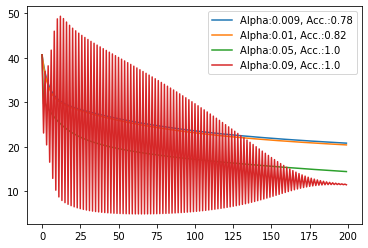

Best alpha is 0.05
with accuracy:  1.0


In [ ]:
theta_arr = []
cost_arr = []
accuracy_arr = []

# design your own learning rate and num iterations
alpha_arr = np.array([0.009, 0.01, 0.05, 0.09])
iterations_arr = np.array([50,100,200,400])

m, n = X_train.shape
theta_initial = np.ones((num_class, n)) 

for alpha in alpha_arr:
    theta, cost = my_gradient_descent(X_train, y_train, theta_initial, alpha,200, num_class)
    
#     y_pred = []

    for index, row in X_test.iterrows():
      y_hat = h(row, theta, num_class)
      prediction = int(np.argmax(y_hat))
      y_pred.append(prediction)
    
      theta_arr.append(theta)
      cost_arr.append(cost)
      y_pred = predict(X_test, theta, num_class)

    accuracy = calc_accuracy(y_test, y_pred)
    accuracy_arr.append(accuracy)
    plt.plot(cost, label="Alpha:" + str(alpha)+", Acc.:"+str(np.round(accuracy, 2)))

plt.legend() 
plt.show() 

max_acc = np.argmax(accuracy_arr) 

print("Best alpha is", alpha_arr[max_acc]) 
print("with accuracy: ", accuracy_arr[max_acc])

**Expected result**: <span style="color:blue">(*Yours doesn't have to be the same!*)</span>

![lab4-02.png](attachment:lab4-02.png)

## On your own to take home

We see that the Iris dataset is pretty easy. Depending on the train/test split, we get 95-100% accuracy.

Find a more interesting multi-class classification problem on Kaggle (Tell the reference), clean the dataset to obtain numerical input features without missing values,
split the data into test and train, and experiment with multinomial logistic regression.

Write a brief report on your experiments and results. As always, turn in a Jupyter notebook by email
to the instructor and TA.


In [ ]:
import pandas as pd
import numpy as np

# **Import Data**

In [ ]:
data = pd.read_excel('Date_Fruit_Datasets.xlsx')

In [ ]:
#Check the data columns
data.columns

Index(['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY',
       'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO',
       'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2',
       'SHAPEFACTOR_3', 'SHAPEFACTOR_4', 'MeanRR', 'MeanRG', 'MeanRB',
       'StdDevRR', 'StdDevRG', 'StdDevRB', 'SkewRR', 'SkewRG', 'SkewRB',
       'KurtosisRR', 'KurtosisRG', 'KurtosisRB', 'EntropyRR', 'EntropyRG',
       'EntropyRB', 'ALLdaub4RR', 'ALLdaub4RG', 'ALLdaub4RB', 'Class'],
      dtype='object')

# **Checking Class by using .unique()**

In [ ]:
data['Class'].unique()

array(['BERHI', 'DEGLET', 'DOKOL', 'IRAQI', 'ROTANA', 'SAFAVI', 'SOGAY'],
      dtype=object)

# **Replacing string by using Numeric**

In [ ]:
data['Class'].replace('BERHI', 1, inplace=True)
data['Class'].replace('DEGLET', 2, inplace=True)
data['Class'].replace('DOKOL', 3, inplace=True)
data['Class'].replace('IRAQI', 4, inplace=True)
data['Class'].replace('ROTANA', 5, inplace=True)
data['Class'].replace('SAFAVI', 6, inplace=True)
data['Class'].replace('SOGAY', 7, inplace=True)

In [ ]:
#Checking that the "class" columns is replaced by numeric
data['Class'].sample(10)

550    5
109    2
458    5
867    7
95     2
167    3
536    5
484    5
691    6
757    6
Name: Class, dtype: int64

In [ ]:
data.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Class
0,422163,2378.908,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400,1
1,338136,2085.144,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315,1
2,526843,2647.394,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378,1
3,416063,2351.210,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882,1
4,347562,2160.354,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666,1


In [ ]:
Xf = data.iloc[:, 0:-1]
yf = data.iloc[:, -1]
print(Xf.shape, yf.shape)

(898, 34) (898,)


# **Seperating data**

This dataset used percent training = 70 %

In [ ]:
percent_train = 0.7
idx, X_train, y_train, X_test, y_test, y_labels_name, y_labels_new = partition(Xf, yf, percent_train)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(628, 34) (628,) (270, 34) (270,)


In [ ]:
X_train.shape

(628, 34)

# **Data normalization**

In [ ]:
def normalization(X):
    """
    Take in numpy array of X values and return normalize X values,
    the mean and standard deviation of each feature
    """
    X_norm = None

    X_norm = (X-np.mean(X))/(np.std(X))
    return X_norm

In [ ]:
X_norm_train = normalization(X_train)
X_norm_train

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB
0,0.060312,0.090832,0.234109,0.008993,0.407285,0.152294,0.317591,0.043528,-0.391525,0.183594,...,1.048614,-0.121287,2.657573,0.757720,1.207136,1.137595,0.909073,-1.503844,-1.421329,-1.161051
1,-0.311386,0.775066,0.960014,-0.970174,1.871712,-0.203333,-1.297846,-0.256687,-4.004409,3.494940,...,0.466147,1.400094,0.877152,-0.105438,1.207314,1.079524,0.909887,-1.517171,-1.233186,-0.999507
2,-1.447809,-1.557555,-1.593399,-1.279327,0.006738,-1.499655,0.495764,-1.464487,0.487692,-0.248361,...,-0.764867,-0.135706,-0.523132,-0.621612,0.428546,0.411319,0.552704,0.753812,0.900614,0.900019
3,-0.032619,0.207518,0.597626,-0.390368,1.191014,0.065655,-0.507945,-0.009550,-1.477838,1.438298,...,2.302317,2.416531,2.814433,3.938177,1.412430,1.424211,1.534064,-2.072477,-1.982636,-2.394252
4,1.664942,1.171699,0.898375,1.772883,-1.461163,1.471793,0.662059,1.617823,1.304780,-1.263039,...,1.275009,0.156512,0.117534,1.915850,-0.653304,-0.951870,-0.772829,-0.125253,-0.013926,-0.308619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,0.758946,0.634187,0.528251,0.821198,-0.418120,0.763102,0.341347,0.738952,-0.062054,-0.616494,...,-0.297005,-0.753212,-0.822882,-0.598291,-0.906844,-0.919812,-0.700545,0.386627,0.306778,0.145324
624,1.157409,0.721002,0.610959,1.296264,-1.101134,1.084723,0.846172,1.102275,0.310719,-1.071573,...,1.757445,1.744657,0.910403,2.092834,0.511573,0.184564,-0.091770,-0.862473,-0.656920,-0.640785
625,-0.142890,-0.050793,0.006109,-0.123054,0.332037,-0.039055,-0.014999,-0.143810,-0.675811,0.095723,...,-0.079553,-0.741698,-0.842164,-0.512801,0.226008,0.315507,0.716304,-0.174781,-0.298232,-0.855535
626,1.055550,0.688976,0.528292,1.236603,-1.139336,1.004107,0.703633,1.011163,-0.229613,-1.093772,...,0.234121,0.303173,0.635961,0.971763,0.146055,-0.150586,-0.729800,-0.518817,-0.336266,-0.000192


In [ ]:
X_norm_train.insert(0, "intercept", 1)
X_norm_train.shape

(628, 35)

In [ ]:
m, n = X_train.shape
num_class = len(data['Class'].unique())


theta_initial = np.ones((num_class, n+1))
alpha = .001
iterations = 100

# theta = None blabla

theta = gradient_descent(X_norm_train, y_train, theta_initial, alpha, iterations, num_class)

In [ ]:
#X_test.drop(columns=['intercept'], inplace=True)
X_norm_test = normalization(X_test)
X_norm_test.insert(0, "intercept", 1)

In [ ]:
X_test.insert(0, "intercept", 1)

In [ ]:
# Prediction on test data 
# X_test.insert(0, "intercept", 1)

# Reset m and n for test data
r,c = X_norm_test.shape
print(r,c)

y_pred = []
for index,row in X_norm_test.iterrows(): # get a row of X_test data
    # calculate y_hat using hypothesis function
    y_hat = None

    # find the index (integer value) of maximum value in y_hat and input back to prediction
    prediction = None
    # YOUR CODE HERE

    y_hat = h(row, theta, num_class)
    prediction = int(np.argmax(y_hat))

   # raise NotImplementedError()
    # collect the result
    y_pred.append(prediction)

270 35


In [ ]:
accuracyf = calc_accuracy(y_test, y_pred)
print("The Accuracy is :", accuracyf)

The Accuracy is : 0.674074074074074


# **Conclusion**

Around the world, a large number of fruits of various varieties are grown. External appearance characteristics such as color, length, diameter, and shape identify the type of fruit. The outward look of the fruits is an important factor in determining the fruit type. Determining the type of fruits based on their outward appearance may need skill, which is time-consuming and labor-intensive. 

The purpose of this study is to use multinomial logistic regression methods to classify the date fruit varieties Barhee, Deglet Nour, Sukkary, Rotab Mozafati, Ruthana, Safawi, and Sagai. I use alpha  .004 and  iterations = 100

The accuracy is 67.7 %


**Reference:** https://www.kaggle.com/datasets/muratkokludataset/date-fruit-datasets/code?fbclid=IwAR0SjEPjeV-hry6hDY1uUfj70BThJsTAkOaXlDJF7h6F6jwGLtdzuCrCspA